In [ ]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [2]:
#@title Load coordinates nearest points

import time
import plotly.express as px
import pandas as pd
from scipy.stats import shapiro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMRegressor
import pickle
from sklearn.pipeline import Pipeline

coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/distan_lat43.302lon-8.377p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Shapiro test normality

p value: 6.06357302082995e-15
Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable

Observed wind intensity statistics


count    89587.000000
mean         3.104465
std          2.091890
min          0.000000
25%          1.543332
50%          2.572220
75%          4.115552
max         16.462208
Name: spd_o, dtype: float64

,MAE,MSE,R2,MedianAE
Point 0,1.09,2.09,0.51,0.84
Point 1,1.19,2.51,0.41,0.93
Point 2,1.48,4.13,0.04,1.08
Point 3,1.31,3.15,0.27,0.98


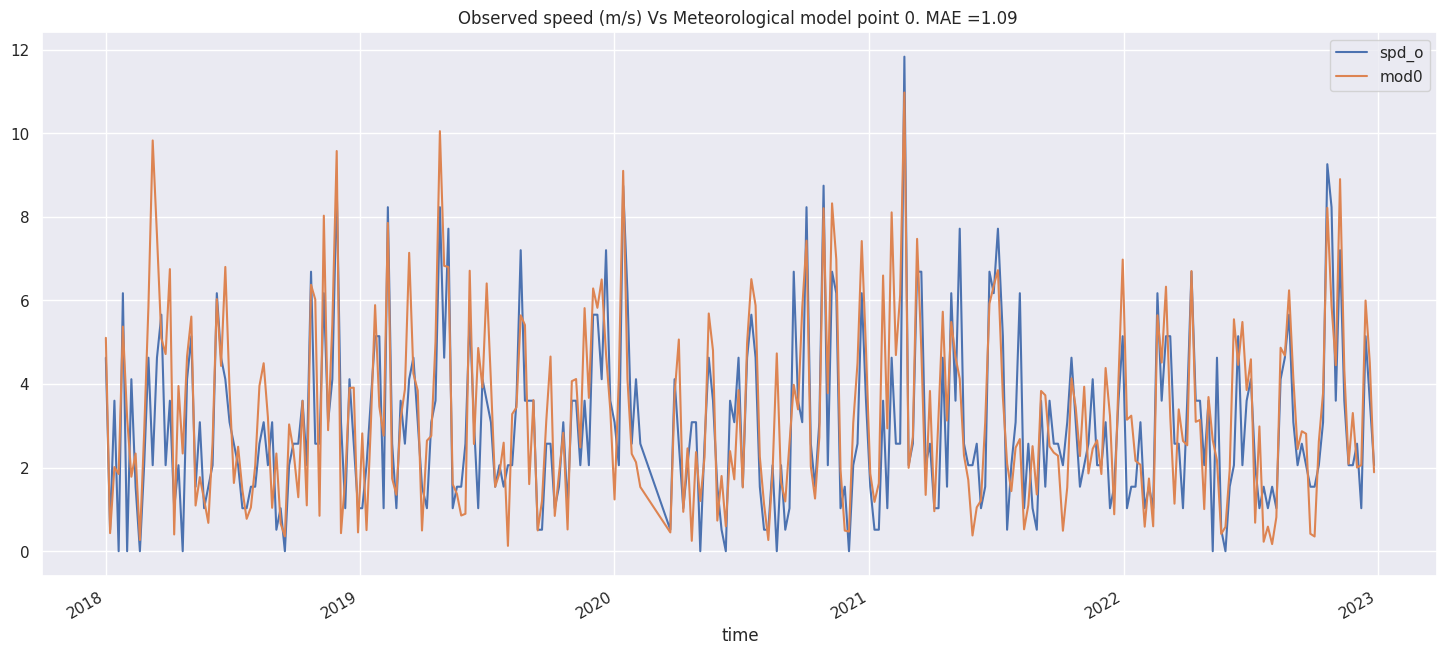

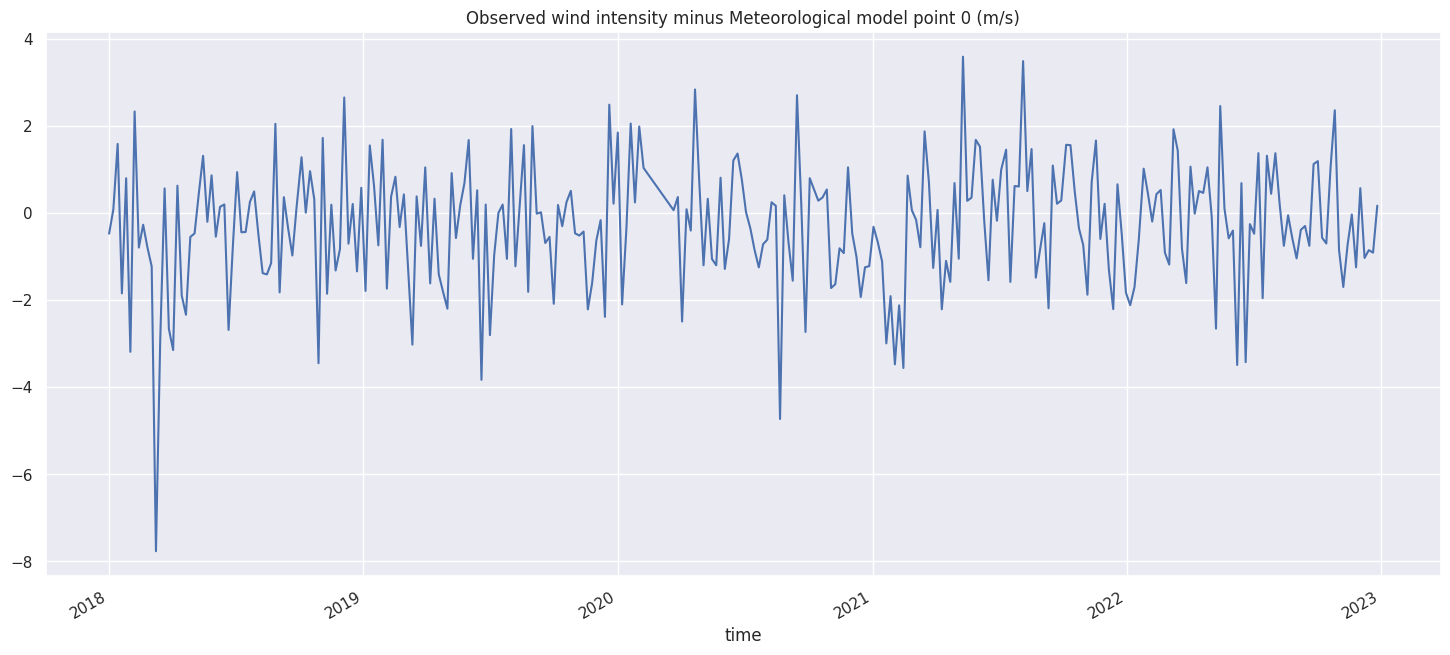

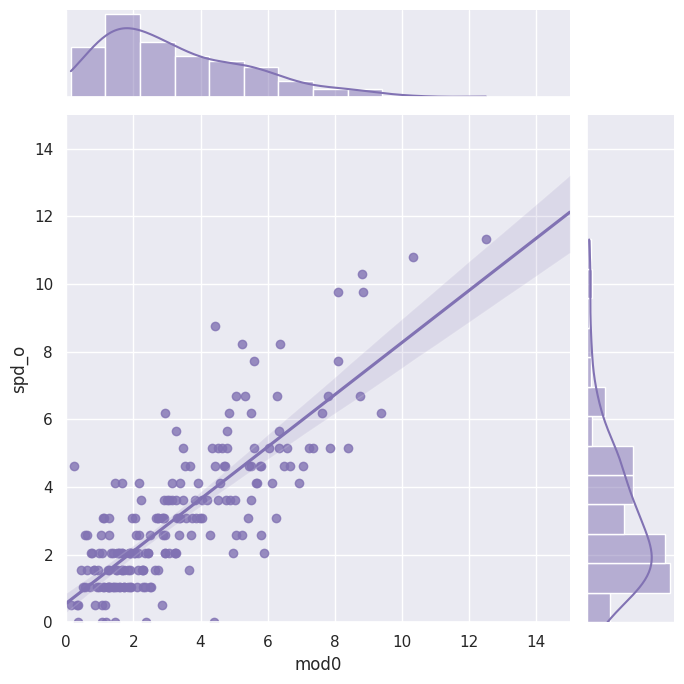

In [12]:
#@title Load station and meteorological model (Forecast D0). Concatenate station and meteorological model. Meteorological model score

station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/LECOY2018Y2022.csv",
                          usecols = ["time","spd_o"],
                          parse_dates=["time"]).set_index("time")

#Shapiro test normality
print("Shapiro test normality")
sta, p = shapiro(station.spd_o.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  

print("Observed wind intensity statistics")
display(station["spd_o"].describe())

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2022.csv",parse_dates=["time"])
model1k = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station model
df_all = pd.concat([station,model1k],axis=1).dropna()

#metmodel score point 0
#Mean absolute error
MAE0 = round(mean_absolute_error(df_all["spd_o"], df_all["mod0"]),2)
#MSE 
MSE0 = round(mean_squared_error(df_all["spd_o"], df_all["mod0"]),2)
#R2
R20 = round(r2_score(df_all["spd_o"], df_all["mod0"]),2)
#Median absolute error
MedianAE0 = round(median_absolute_error(df_all["spd_o"], df_all["mod0"]),2)

#metmodel score point 1
#Mean absolute error
MAE1 = round(mean_absolute_error(df_all["spd_o"], df_all["mod1"]),2)
#MSE 
MSE1 = round(mean_squared_error(df_all["spd_o"], df_all["mod1"]),2)
#R2
R21 = round(r2_score(df_all["spd_o"], df_all["mod1"]),2)
#Median absolute error
MedianAE1 = round(median_absolute_error(df_all["spd_o"], df_all["mod1"]),2)

#metmodel score point 2
#Mean absolute error
MAE2 = round(mean_absolute_error(df_all["spd_o"], df_all["mod2"]),2)
#MSE 
MSE2 = round(mean_squared_error(df_all["spd_o"], df_all["mod2"]),2)
#R2
R22 = round(r2_score(df_all["spd_o"], df_all["mod2"]),2)
#Median absolute error
MedianAE2 = round(median_absolute_error(df_all["spd_o"], df_all["mod2"]),2)

#metmodel score point 3
#Mean absolute error
MAE3 = round(mean_absolute_error(df_all["spd_o"], df_all["mod3"]),2)
#MSE 
MSE3 = round(mean_squared_error(df_all["spd_o"], df_all["mod3"]),2)
#R2
R23 = round(r2_score(df_all["spd_o"], df_all["mod3"]),2)
#Median absolute error
MedianAE3 = round(median_absolute_error(df_all["spd_o"], df_all["mod3"]),2)


df_r =pd.DataFrame({"Point 0":[MAE0,MSE0,R20,MedianAE0],
                    "Point 1":[MAE1,MSE1,R21,MedianAE1],
                    "Point 2":[MAE2,MSE2,R22,MedianAE2],
                    "Point 3":[MAE3,MSE3,R23,MedianAE3]},index = ["MAE","MSE","R2","MedianAE"])

display(df_r.T)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
df_all[["spd_o","mod0"]][0::140].plot(ax=ax,grid =True,);
title = "Observed speed (m/s) Vs Meteorological model point 0. MAE ={} ".format(MAE0)
ax.set_title(title)
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
(df_all["spd_o"]-df_all["mod0"])[0::140].plot(ax=ax,grid =True,);
ax.set_title("Observed wind intensity minus Meteorological model point 0 (m/s)")
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model

sns.set_theme(style="darkgrid")
sns.jointplot(x="mod0", y="spd_o", data=df_all.sample(200),
                  kind="reg", truncate=False,
                  xlim=(0, 15), ylim=(0, 15),
                  color="m", height=7,);


Machine learning results


,MAE,MSE,R2,Median_AE
0,0.85,1.28,0.70,0.66
1,0.87,1.35,0.69,0.68
2,0.85,1.27,0.71,0.67
3,0.86,1.29,0.70,0.67
4,0.86,1.30,0.69,0.66
5,0.85,1.28,0.71,0.68
6,0.86,1.32,0.69,0.67
7,0.85,1.32,0.70,0.65
8,0.85,1.28,0.70,0.66
9,0.87,1.33,0.71,0.68


Comparing differences machine learning meteorological model


,dif_met,dif_ml
count,6127.000000,6127.000000
mean,0.206630,-0.026369
std,1.440897,1.153926
min,-6.680649,-6.518343
25%,-0.687533,-0.684024
50%,0.139096,0.009168
75%,1.050062,0.688337
max,9.013183,8.271409


Shapiro test normality differences meteorologic model

p value: 1.043734254579931e-08
Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable

Shapiro test normality differences machine learning model

p value: 0.025694899260997772
Accept null hypothesis: normal distribution variable

Execution time: 0.65 minutes


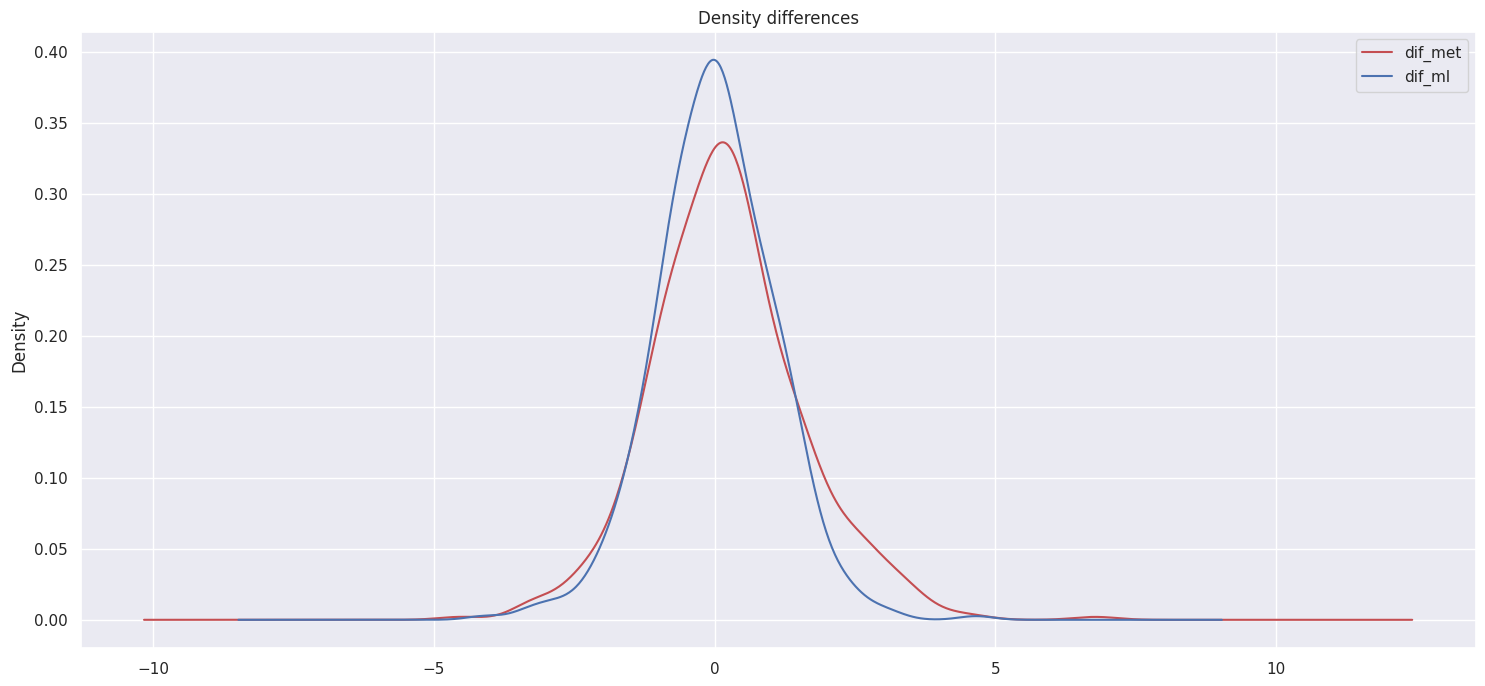

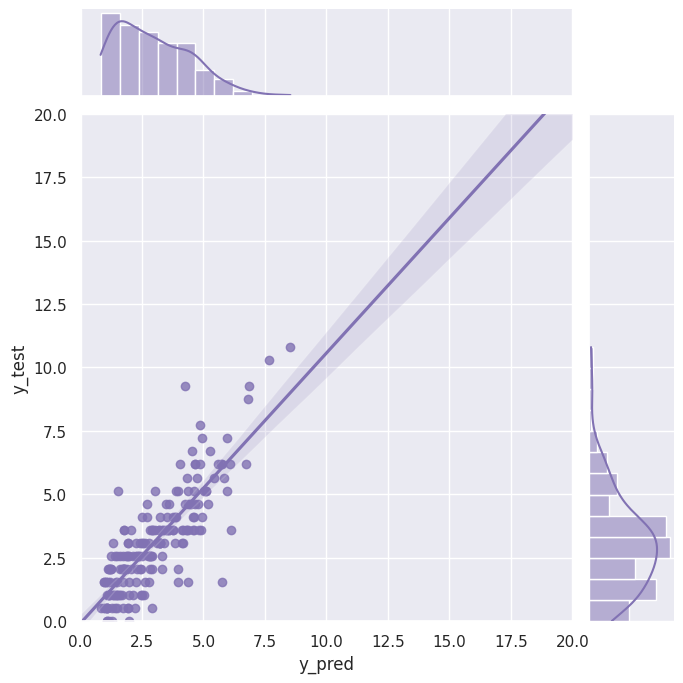

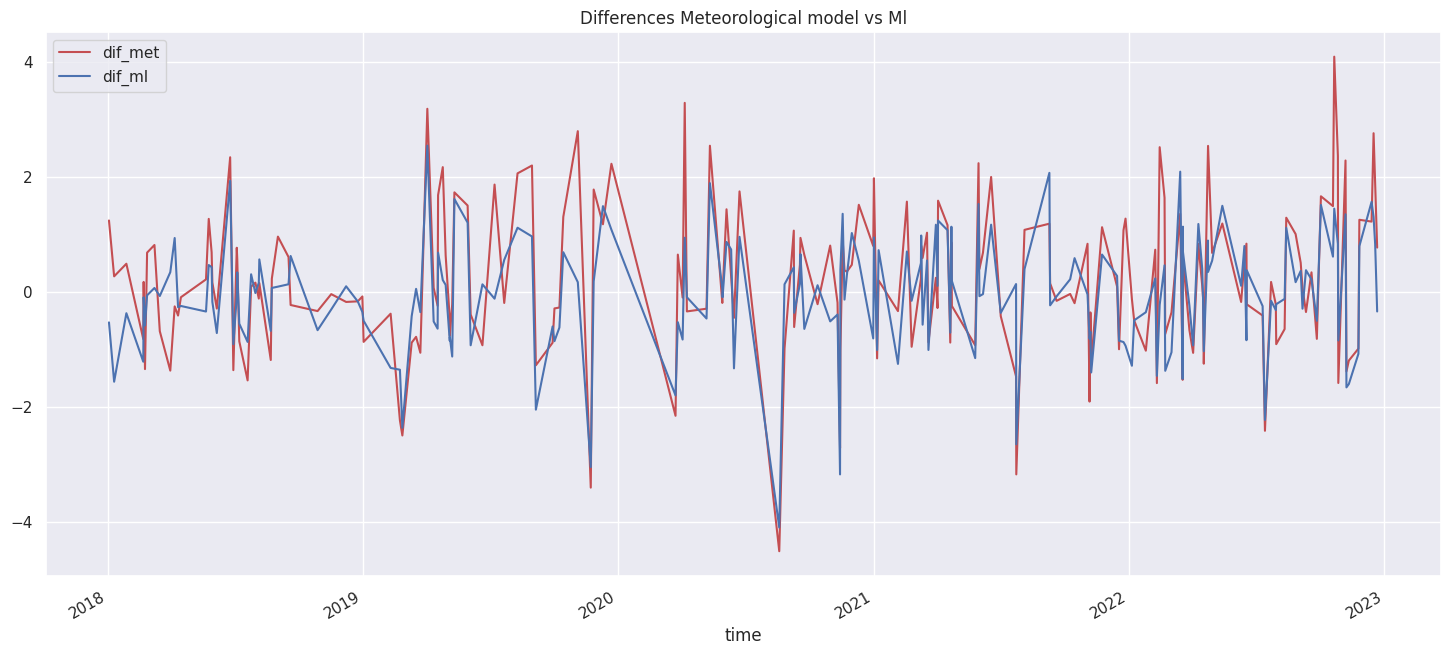

In [14]:
#@title Add time variables. Machine learning algorithm score. Save algorithm

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)
df_all.iloc[:,1:].columns

#random seed 1
np.random.seed(1)

# X and Y
Y = df_all.spd_o
X = df_all.iloc[:,1:]

# loop random
Median_AE_ml = []
Mean_AE_ml =[]
MSE_ml = []
R2_ml = []

#20 samples to test algorithm
#random seed 1
np.random.seed(1)
print("Machine learning results")
for t in range (0,10):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, )

  #machine learning model
  ml_model = LGBMRegressor().fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  
  #Score calculation
  Mean_AE_ml.append(round(mean_absolute_error(y_test, y_pred),2))
  Median_AE_ml.append(round(median_absolute_error(y_test, y_pred),2))
  MSE_ml.append (round(mean_squared_error(y_test, y_pred),2))
  R2_ml.append(round(r2_score(y_test, y_pred),2))

display(pd.DataFrame({"MAE":Mean_AE_ml,"MSE":MSE_ml,"R2":R2_ml,"Median_AE":Median_AE_ml}))  

#show results sample 200
result = pd.DataFrame({"y_pred":y_pred,"y_test":y_test.values,"mod0":X_test.mod0.values}).set_index(y_test.index)

result["dif_met"]=result['mod0']-result['y_test']
result["dif_ml"]=result['y_pred']-result['y_test']
print("Comparing differences machine learning meteorological model")
display(result[["dif_met","dif_ml"]].describe())

result[["dif_met","dif_ml"]].sample(500).plot(figsize=(18, 8),grid =True,color=["r","b"],kind="kde",title="Density differences");

sns.set_theme(style="darkgrid")
g = sns.jointplot(x="y_pred", y="y_test", data=result.sample(200),
                  kind="reg", truncate=False,
                  xlim=(0, 20), ylim=(0, 20),
                  color="m", height=7)

result[["dif_met","dif_ml"]].sample(200).plot(figsize=(18, 8),grid =True,color=["r","b"], title="Differences Meteorological model vs Ml");

#Shapiro test normality meteorologic model
print("Shapiro test normality differences meteorologic model")
sta, p = shapiro(result.dif_met.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  

#Shapiro test normality machine learning model
print("Shapiro test normality differences machine learning model")
sta, p = shapiro(result.dif_ml.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  


#download algorithm
x_var = X.columns
score = {"MAE_met":MAE0,"MAE_ml":Mean_AE_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/spd_LECO_d0.al", 'wb'))

#time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", round(execution_time/60,2), "minutes")

,MAE,MSE,R2,MedianAE
Point 0,1.17,2.45,0.43,0.89
Point 1,1.28,2.94,0.32,0.98
Point 2,1.57,4.77,-0.11,1.11
Point 3,1.40,3.72,0.14,1.02


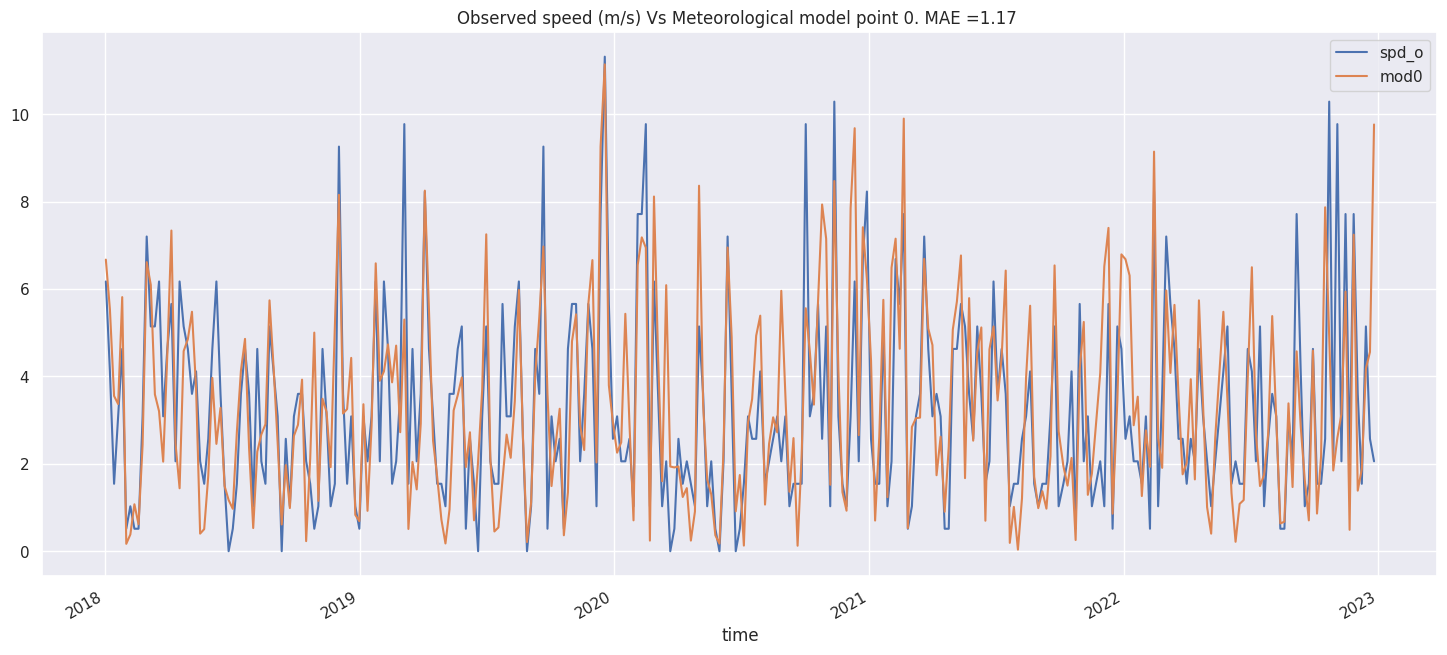

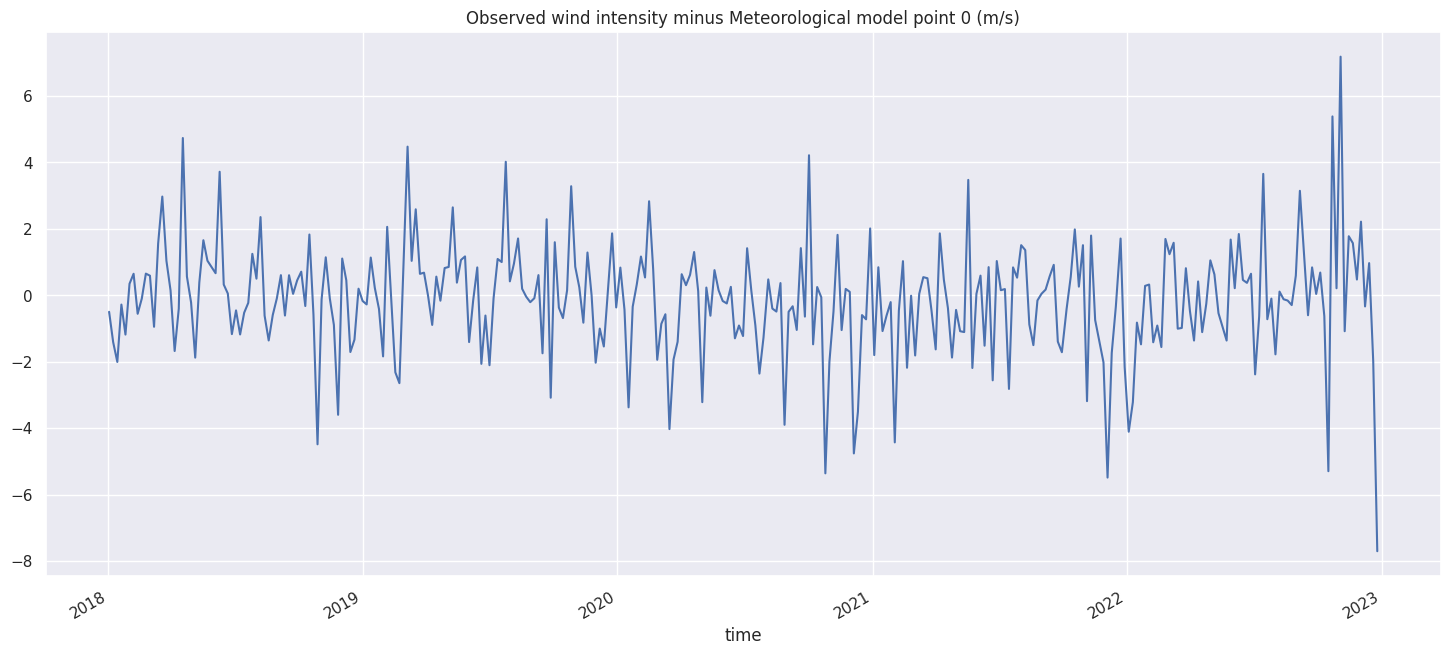

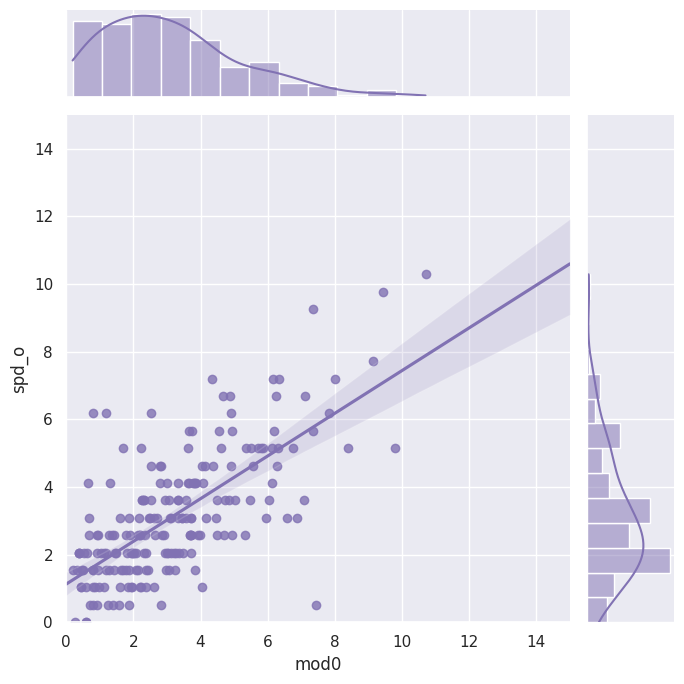

In [15]:
#@title Concatenate station and meteorological model (Forecast D1). Meteorological model score

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2022.csv",parse_dates=["time"])
model1k = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station model
df_all = pd.concat([station,model1k],axis=1).dropna()

#metmodel score point 0
#Mean absolute error
MAE0 = round(mean_absolute_error(df_all["spd_o"], df_all["mod0"]),2)
#MSE 
MSE0 = round(mean_squared_error(df_all["spd_o"], df_all["mod0"]),2)
#R2
R20 = round(r2_score(df_all["spd_o"], df_all["mod0"]),2)
#Median absolute error
MedianAE0 = round(median_absolute_error(df_all["spd_o"], df_all["mod0"]),2)

#metmodel score point 1
#Mean absolute error
MAE1 = round(mean_absolute_error(df_all["spd_o"], df_all["mod1"]),2)
#MSE 
MSE1 = round(mean_squared_error(df_all["spd_o"], df_all["mod1"]),2)
#R2
R21 = round(r2_score(df_all["spd_o"], df_all["mod1"]),2)
#Median absolute error
MedianAE1 = round(median_absolute_error(df_all["spd_o"], df_all["mod1"]),2)

#metmodel score point 2
#Mean absolute error
MAE2 = round(mean_absolute_error(df_all["spd_o"], df_all["mod2"]),2)
#MSE 
MSE2 = round(mean_squared_error(df_all["spd_o"], df_all["mod2"]),2)
#R2
R22 = round(r2_score(df_all["spd_o"], df_all["mod2"]),2)
#Median absolute error
MedianAE2 = round(median_absolute_error(df_all["spd_o"], df_all["mod2"]),2)

#metmodel score point 3
#Mean absolute error
MAE3 = round(mean_absolute_error(df_all["spd_o"], df_all["mod3"]),2)
#MSE 
MSE3 = round(mean_squared_error(df_all["spd_o"], df_all["mod3"]),2)
#R2
R23 = round(r2_score(df_all["spd_o"], df_all["mod3"]),2)
#Median absolute error
MedianAE3 = round(median_absolute_error(df_all["spd_o"], df_all["mod3"]),2)


df_r =pd.DataFrame({"Point 0":[MAE0,MSE0,R20,MedianAE0],
                    "Point 1":[MAE1,MSE1,R21,MedianAE1],
                    "Point 2":[MAE2,MSE2,R22,MedianAE2],
                    "Point 3":[MAE3,MSE3,R23,MedianAE3]},index = ["MAE","MSE","R2","MedianAE"])

display(df_r.T)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
df_all[["spd_o","mod0"]][0::140].plot(ax=ax,grid =True,);
title = "Observed speed (m/s) Vs Meteorological model point 0. MAE ={} ".format(MAE0)
ax.set_title(title)
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
(df_all["spd_o"]-df_all["mod0"])[0::140].plot(ax=ax,grid =True,);
ax.set_title("Observed wind intensity minus Meteorological model point 0 (m/s)")
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model

sns.set_theme(style="darkgrid")
sns.jointplot(x="mod0", y="spd_o", data=df_all.sample(200),
                  kind="reg", truncate=False,
                  xlim=(0, 15), ylim=(0, 15),
                  color="m", height=7,);


Machine learning results


,MAE,MSE,R2,Median_AE
0,0.90,1.47,0.67,0.70
1,0.91,1.53,0.65,0.70
2,0.89,1.45,0.67,0.69
3,0.90,1.46,0.67,0.71
4,0.90,1.51,0.66,0.69
5,0.90,1.44,0.67,0.70
6,0.91,1.49,0.66,0.72
7,0.90,1.46,0.67,0.68
8,0.90,1.46,0.65,0.69
9,0.90,1.47,0.66,0.70


Comparing differences machine learning meteorological model


,dif_met,dif_ml
count,6529.000000,6529.000000
mean,0.251350,0.004766
std,1.554302,1.213289
min,-7.181655,-7.208101
25%,-0.678257,-0.650801
50%,0.202720,0.062014
75%,1.106907,0.734532
max,8.037696,6.077760


Shapiro test normality differences meteorologic model

p value: 3.894250767189078e-06
Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable

Shapiro test normality differences machine learning model

p value: 1.3575991886227712e-07
Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable

Execution time: 0.61 minutes


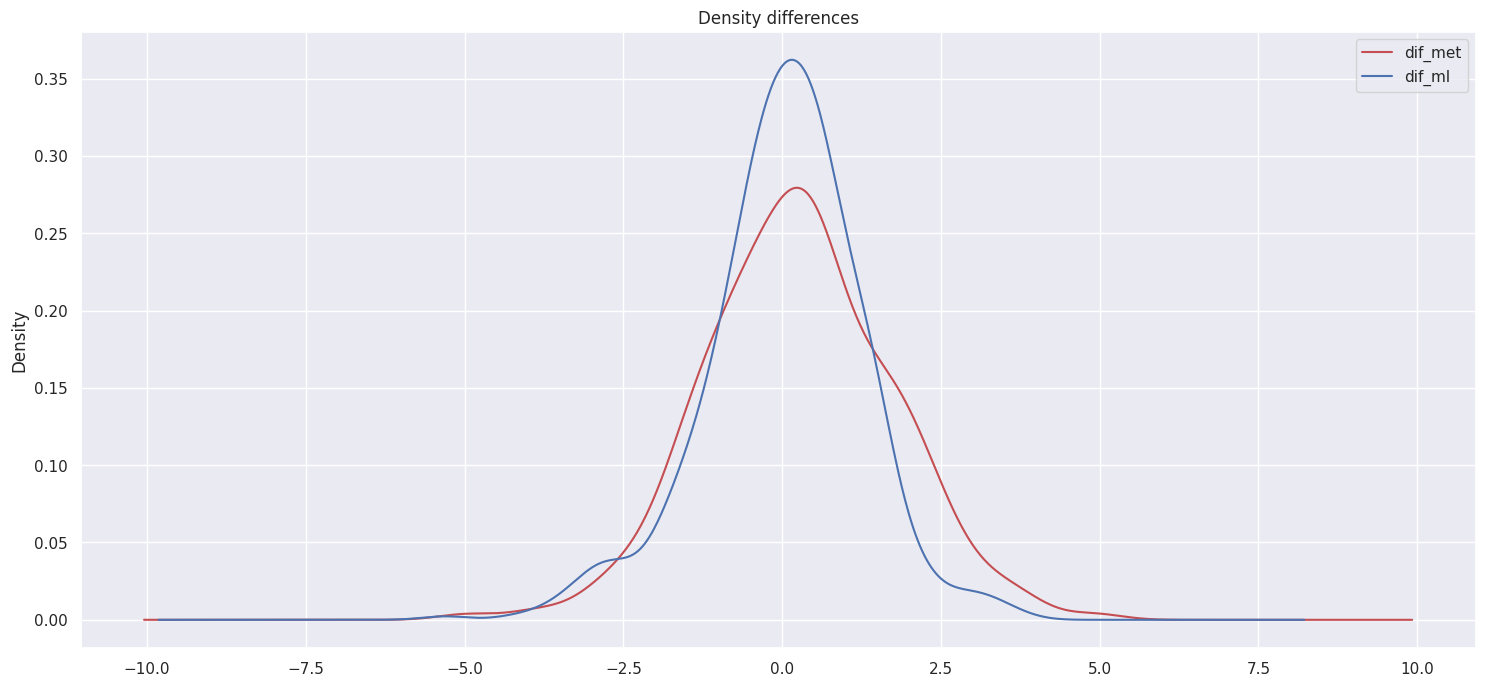

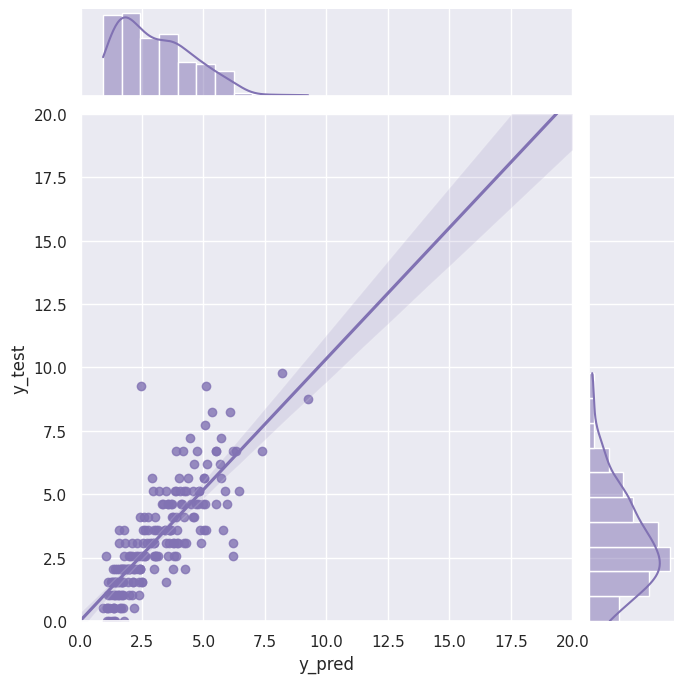

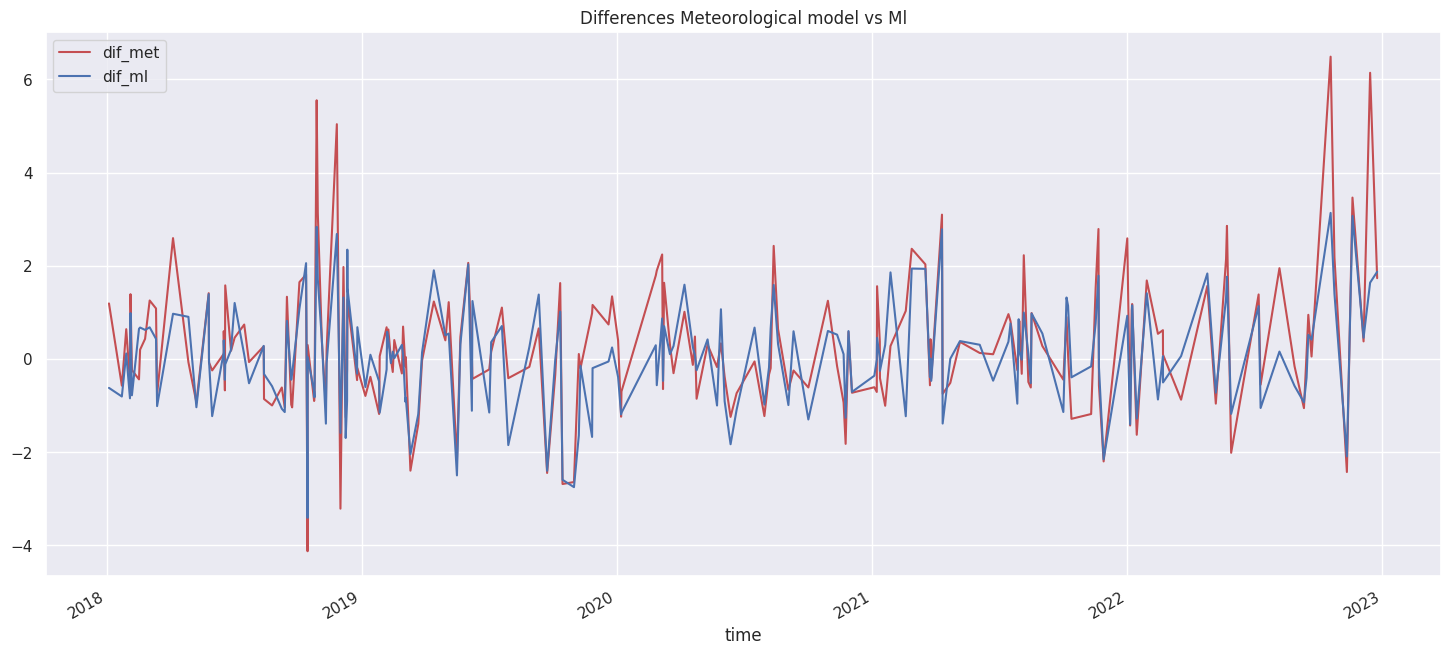

In [16]:
#@title Add time variables. Machine learning algorithm score. Save algorithm

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)
df_all.iloc[:,1:].columns

#random seed 1
np.random.seed(1)

# X and Y
Y = df_all.spd_o
X = df_all.iloc[:,1:]

# loop random
Median_AE_ml = []
Mean_AE_ml =[]
MSE_ml = []
R2_ml = []

#20 samples to test algorithm
#random seed 1
np.random.seed(1)
print("Machine learning results")
for t in range (0,10):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, )

  #machine learning model
  ml_model = LGBMRegressor().fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  
  #Score calculation
  Mean_AE_ml.append(round(mean_absolute_error(y_test, y_pred),2))
  Median_AE_ml.append(round(median_absolute_error(y_test, y_pred),2))
  MSE_ml.append (round(mean_squared_error(y_test, y_pred),2))
  R2_ml.append(round(r2_score(y_test, y_pred),2))

display(pd.DataFrame({"MAE":Mean_AE_ml,"MSE":MSE_ml,"R2":R2_ml,"Median_AE":Median_AE_ml}))  

#show results sample 200
result = pd.DataFrame({"y_pred":y_pred,"y_test":y_test.values,"mod0":X_test.mod0.values}).set_index(y_test.index)

result["dif_met"]=result['mod0']-result['y_test']
result["dif_ml"]=result['y_pred']-result['y_test']
print("Comparing differences machine learning meteorological model")
display(result[["dif_met","dif_ml"]].describe())

result[["dif_met","dif_ml"]].sample(500).plot(figsize=(18, 8),grid =True,color=["r","b"],kind="kde",title="Density differences");

sns.set_theme(style="darkgrid")
g = sns.jointplot(x="y_pred", y="y_test", data=result.sample(200),
                  kind="reg", truncate=False,
                  xlim=(0, 20), ylim=(0, 20),
                  color="m", height=7)

result[["dif_met","dif_ml"]].sample(200).plot(figsize=(18, 8),grid =True,color=["r","b"], title="Differences Meteorological model vs Ml");

#Shapiro test normality meteorologic model
print("Shapiro test normality differences meteorologic model")
sta, p = shapiro(result.dif_met.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  

#Shapiro test normality machine learning model
print("Shapiro test normality differences machine learning model")
sta, p = shapiro(result.dif_ml.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  


#download algorithm
x_var = X.columns
score = {"MAE_met":MAE0,"MAE_ml":Mean_AE_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/spd_LECO_d1.al", 'wb'))

#time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", round(execution_time/60,2), "minutes")